<a href="https://colab.research.google.com/github/coolvera/Vera-Love/blob/main/Final_projectANAneutralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import platform
import time
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import UndefinedMetricWarning
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
physical_cores = psutil.cpu_count(logical=False)
logical_cores = psutil.cpu_count(logical=True)
os.environ["LOKY_MAX_CPU_COUNT"] = str(physical_cores or 1)
print(f"Physical cores: {physical_cores}, Logical cores: {logical_cores}")
print(f"LOKY_MAX_CPU_COUNT set to {os.environ['LOKY_MAX_CPU_COUNT']}")

Physical cores: 1, Logical cores: 2
LOKY_MAX_CPU_COUNT set to 1


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


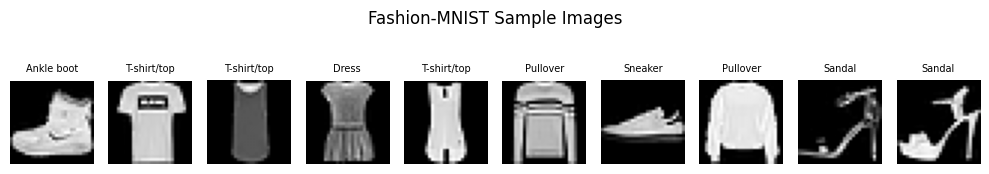

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(class_names[y_train[i]], fontsize=7)
    plt.axis("off")
plt.suptitle("Fashion-MNIST Sample Images")
plt.tight_layout()
plt.show()

In [6]:
print("\nTraining SVM...")
svm = SVC()
params = {'kernel': ['rbf', 'linear'], 'C': [0.1, 1, 10]}
grid = GridSearchCV(svm, params, cv=3, verbose=1, n_jobs=-1)
start_svm = time.time()
grid.fit(x_train_flat[:10000], y_train[:10000])
end_svm = time.time()

best_svm = grid.best_estimator_
svm_preds = best_svm.predict(x_test_flat)
svm_acc = np.mean(svm_preds == y_test)
print(f"SVM Best Params: {grid.best_params_}")
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"SVM Training Time: {end_svm - start_svm:.2f} sec")


Training SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
SVM Best Params: {'C': 10, 'kernel': 'rbf'}
SVM Accuracy: 0.8667
SVM Training Time: 189.05 sec


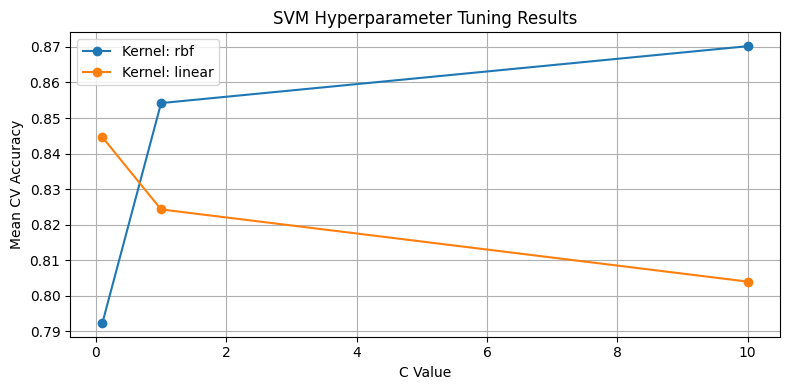

In [7]:
results_df = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8, 4))
for kernel in results_df['param_kernel'].unique():
    subset = results_df[results_df['param_kernel'] == kernel]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'Kernel: {kernel}')
plt.title("SVM Hyperparameter Tuning Results")
plt.xlabel("C Value")
plt.ylabel("Mean CV Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_preds, target_names=class_names))


SVM Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.81      0.81      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.75      0.80      0.77      1000
       Dress       0.86      0.87      0.86      1000
        Coat       0.77      0.79      0.78      1000
      Sandal       0.96      0.95      0.95      1000
       Shirt       0.68      0.64      0.66      1000
     Sneaker       0.92      0.95      0.94      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [9]:
svm_correct = np.sum(svm_preds == y_test)
svm_misclassified = np.sum(svm_preds != y_test)
print(f"SVM Correct Predictions: {svm_correct}")
print(f"SVM Misclassified Predictions: {svm_misclassified}")

SVM Correct Predictions: 8667
SVM Misclassified Predictions: 1333


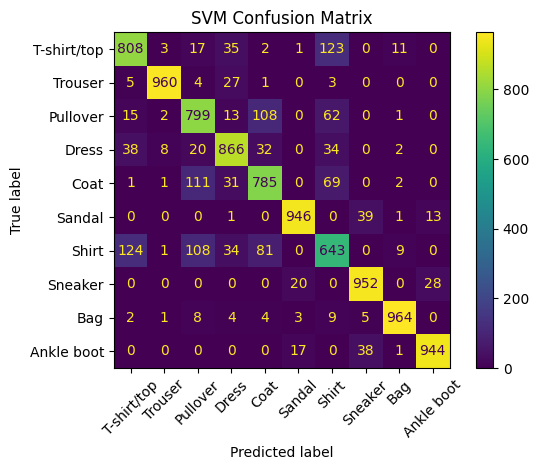

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, svm_preds, display_labels=class_names, xticks_rotation=45)
plt.title("SVM Confusion Matrix")
plt.tight_layout()
plt.show()

In [11]:
x_train_cnn = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test_cnn = x_test.reshape(-1, 28, 28, 1) / 255.0
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [12]:
cnn = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 output classes
])

In [13]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
print("\nCNN Model Summary:")
cnn.summary()


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,162 (879.54 KB)

 Trainable params: 225,098 (879.29 KB)

 Non-trainable params: 64 (256.00 B)

In [21]:
early_stop = EarlyStopping(
    patience=3,               # Stop if no improvement in val_accuracy after 3 epochs
    restore_best_weights=True # Restore model weights from epoch with best val_accuracy
)


In [22]:
start_cnn = time.time()
history = cnn.fit(
    x_train_cnn, y_train_cat,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stop],  # Attach early stopping callback here
    verbose=1
)
end_cnn = time.time()


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7812 - loss: 0.6109 - val_accuracy: 0.8847 - val_loss: 0.3146
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8784 - loss: 0.3361 - val_accuracy: 0.8929 - val_loss: 0.2827
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8963 - loss: 0.2815 - val_accuracy: 0.8911 - val_loss: 0.2941
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9059 - loss: 0.2562 - val_accuracy: 0.9018 - val_loss: 0.2756
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9139 - loss: 0.2302 - val_accuracy: 0.9046 - val_loss: 0.2631
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9217 - loss: 0.2091 - val_accuracy: 0.9068 - val_loss: 0.2555
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9240 - loss: 0.1971 - val_accuracy: 0.9008 - val_loss: 0.2669
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9325 - loss: 0.1780

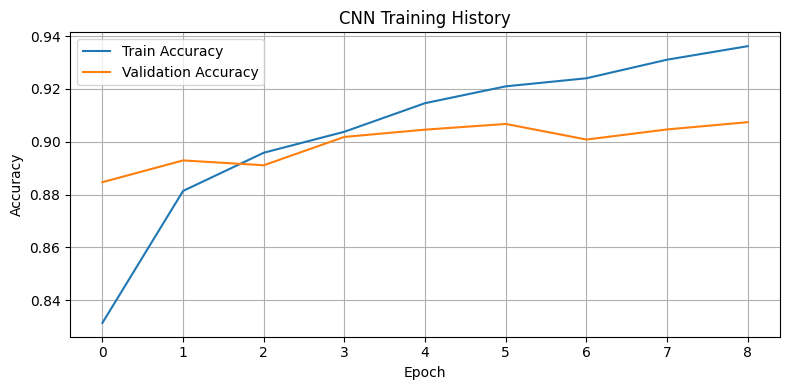

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
cnn_eval = cnn.evaluate(x_test_cnn, y_test_cat, verbose=0)
cnn_preds = np.argmax(cnn.predict(x_test_cnn), axis=1)
print("\nCNN Classification Report:")
print(classification_report(y_test, cnn_preds, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.92      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.88      0.84      0.86      1000
       Dress       0.92      0.89      0.90      1000
        Coat       0.83      0.87      0.85      1000
      Sandal       0.99      0.96      0.97      1000
       Shirt       0.77      0.63      0.69      1000
     Sneaker       0.93      0.98      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
cnn_correct = np.sum(cnn_preds == y_test)
cnn_misclassified = np.sum(cnn_preds != y_test)
print(f"CNN Correct Predictions: {cnn_correct}")
print(f"CNN Misclassified Predictions: {cnn_misclassified}")

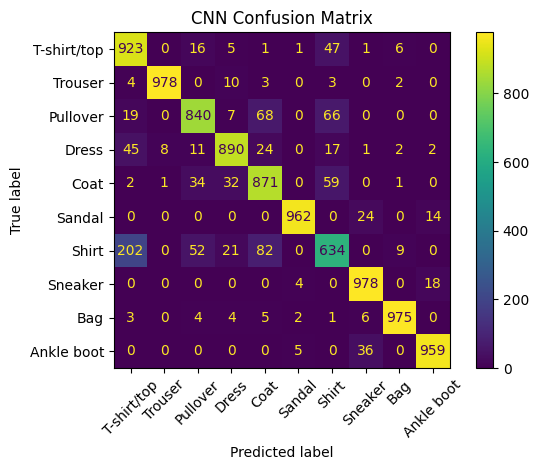

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, cnn_preds, display_labels=class_names, xticks_rotation=45)
plt.title("CNN Confusion Matrix")
plt.tight_layout()
plt.show()

In [27]:
print("\nPerformance Comparison")
print("| Metric              | SVM        | CNN        |")
print("|---------------------|------------|------------|")
print(f"| Test Accuracy       | {svm_acc:.4f}     | {cnn_eval[1]:.4f}     |")
print(f"| Training Time       | {end_svm - start_svm:.2f} sec  | {end_cnn - start_cnn:.2f} sec  |")
print(f"| Misclassifications  | {(y_test != svm_preds).sum()}       | {(y_test != cnn_preds).sum()}        |")
print(f"| Best Validation Acc | N/A        | {best_val_acc:.4f}     |")


Performance Comparison
| Metric              | SVM        | CNN        |
|---------------------|------------|------------|
| Test Accuracy       | 0.8667     | 0.9010     |
| Training Time       | 189.05 sec  | 73.49 sec  |
| Misclassifications  | 1333       | 990        |


NameError: name 'best_val_acc' is not defined

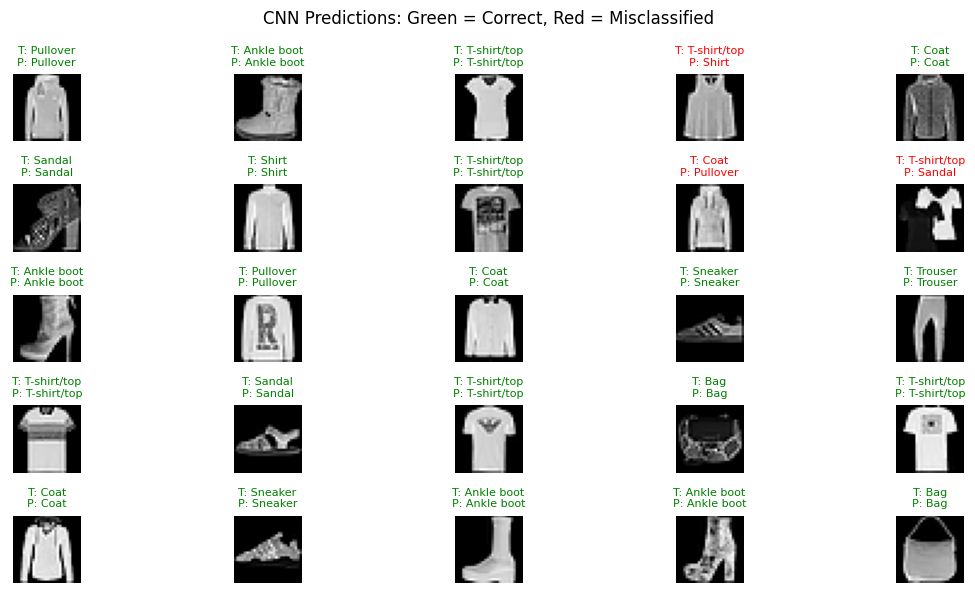

In [28]:
num_samples = 25
indices = np.random.choice(len(x_test), num_samples, replace=False)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    true = class_names[y_test[idx]]
    pred = class_names[cnn_preds[idx]]
    color = 'green' if y_test[idx] == cnn_preds[idx] else 'red'
    plt.title(f"T: {true}\nP: {pred}", color=color, fontsize=8)
    plt.axis('off')
plt.suptitle("CNN Predictions: Green = Correct, Red = Misclassified")
plt.tight_layout()
plt.show()

In [29]:
correct_svm = np.where(svm_preds == y_test)[0]
incorrect_svm = np.where(svm_preds != y_test)[0]
print(f"Correct SVM Predictions: {len(correct_svm)}")
print(f"Misclassified SVM Predictions: {len(incorrect_svm)}")


Correct SVM Predictions: 8667
Misclassified SVM Predictions: 1333


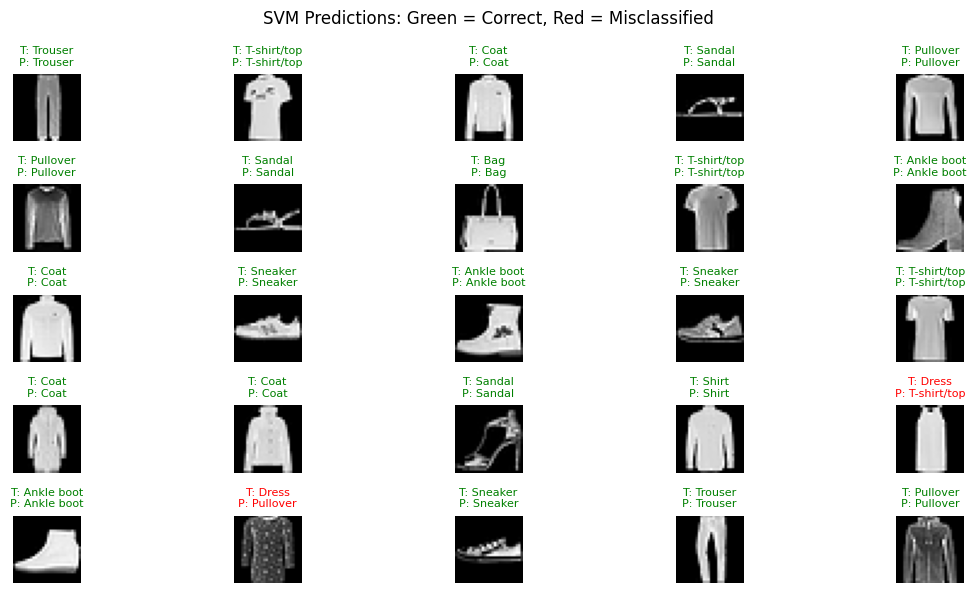

In [30]:
svm_indices = np.random.choice(len(x_test), 25, replace=False)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(svm_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    true = class_names[y_test[idx]]
    pred = class_names[svm_preds[idx]]
    color = 'green' if y_test[idx] == svm_preds[idx] else 'red'
    plt.title(f"T: {true}\nP: {pred}", color=color, fontsize=8)
    plt.axis('off')
plt.suptitle("SVM Predictions: Green = Correct, Red = Misclassified")
plt.tight_layout()
plt.show()

In [31]:
total_runtime = time.time() - start_svm
print("\nSystem and Runtime Summary:")
print(f"Total execution time: {total_runtime:.2f} seconds")
print(f"CPU Cores Used: {os.environ['LOKY_MAX_CPU_COUNT']} / {logical_cores} logical cores")
print(f"Platform: {platform.system()} {platform.release()} ({platform.processor()})")


System and Runtime Summary:
Total execution time: 1920.15 seconds
CPU Cores Used: 1 / 2 logical cores
Platform: Linux 6.1.123+ (x86_64)
